In [1]:
import requests
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

url ="https://www.alphavantage.co/query"

params = {
    "function":"TIME_SERIES_DAILY_ADJUSTED",
    "symbol": "AAPL",
    "apikey": "TU10HCWDTV5CNVBN"
}

response = requests.get(url, params=params)
data = response.json()

def convert_response(d):
    for dt, prec in d['Time Series (Daily)'].items():
        r = {'datetime': dt}
        r.update(prec)
        yield r

df = pd.DataFrame(convert_response(data))
# rename the columns    
df = df.rename(columns={ '1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. adjusted close': 'AdjClose', '6. volume': 'Volume'})
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)
# extract the columns you want
df = df[[ 'Close']]
df.head()

,Close
datetime,
2018-06-20,186.5000
2018-06-21,185.4600
2018-06-22,184.9200
2018-06-25,182.1700
2018-06-26,184.4300


In [2]:
df.describe().transpose()

,count,unique,top,freq
Close,100,99,226.8700,2


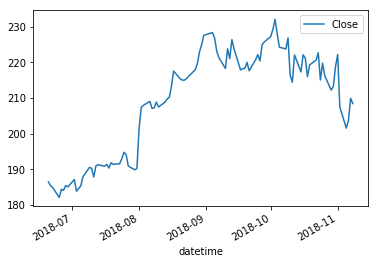

In [3]:
df=df.astype(float)
df.plot()

In [4]:
timeseries = df['Close']

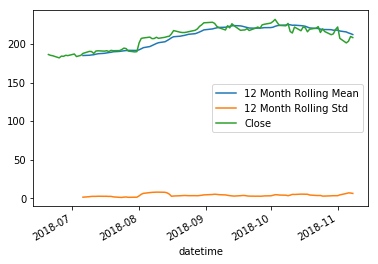

In [5]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

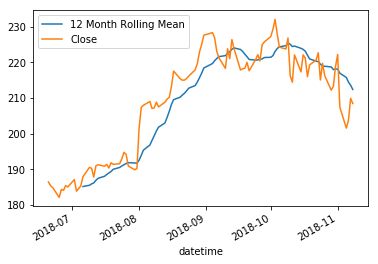

In [6]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.plot()
plt.legend()

## Descomposiciones
## LA DESCOMPOSICION ETS nos permite ver las partes 

<Figure size 432x288 with 0 Axes>

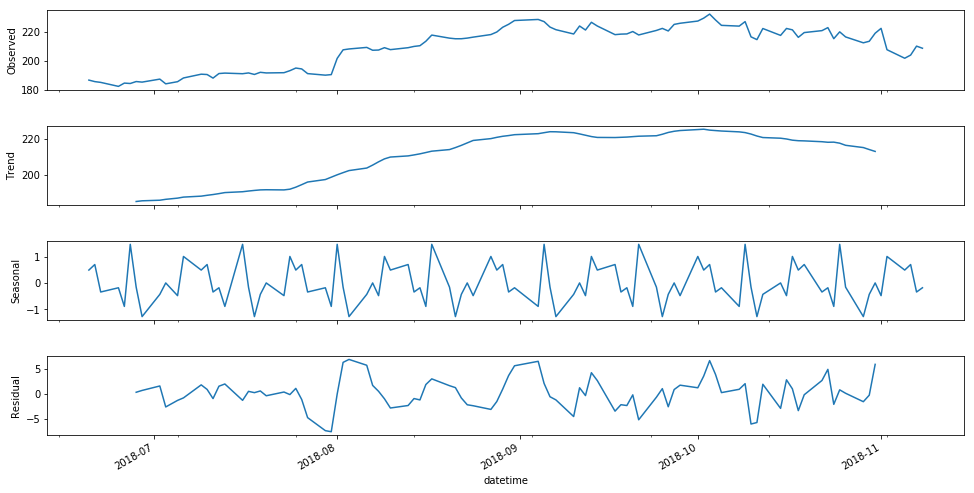

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Close'], freq=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

# TESTING PARA Stationarity

In [8]:
df.head()

,Close
datetime,
2018-06-20,186.50
2018-06-21,185.46
2018-06-22,184.92
2018-06-25,182.17
2018-06-26,184.43


In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
result = adfuller(df['Close'])

In [11]:
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used']

for value, label in zip(result,labels):
    print(label+' : '+str(value))
    
if result[1] <= 0.05:
    print("Los datos no tienen raíz unitaria y son estacionarios.")
else:
    print("evidencia débil contra hipótesis nula, las series de tiempo tienen una raíz unitaria, lo que indica que no es estacionaria")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.7326122057554887
p-value : 0.41439282564007446
#lags Used : 0
Number of Observations Used : 99
evidencia débil contra hipótesis nula, las series de tiempo tienen una raíz unitaria, lo que indica que no es estacionaria


In [12]:
# Store in a function for later use:

def adf_check(time_series):
    """
        Pasar en una serie de tiempo, regresar reporteADF
    """
    
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test')
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
        
    if result[1] <= 0.05:
        print("evidencia fuerte contra la hipótesis nula, rechazar hipótesis nula. Los datos no tienen una raíz unitaria, lo que indica que es estacionaria")
    else:
        print("evidencia débil contra hipótesis nula, las series de tiempo tienen una raíz unitaria, lo que indica que no es estacionaria")

In [13]:
df['Close First Difference'] = df['Close'] - df['Close'].shift(1)

In [14]:
adf_check(df['Close First Difference'].dropna())

Augmented Dickey-Fuller Test
ADF Test Statistic : -8.525295367978059
p-value : 1.0732527722822055e-13
# Lags Used : 1
Number of Observations Used : 97
evidencia fuerte contra la hipótesis nula, rechazar hipótesis nula. Los datos no tienen una raíz unitaria, lo que indica que es estacionaria


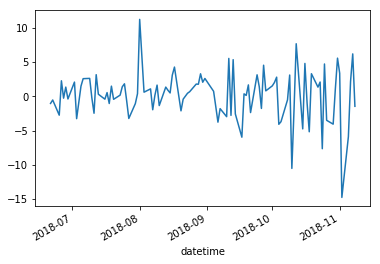

In [15]:
df['Close First Difference'].plot()

In [16]:
# Sometimes it would be necessary to do a second difference
# This is just for show, we didn't need to do a second difference in our case
df['Close Second Difference'] = df['Close First Difference'] - df['Close First Difference'].shift(1)

In [17]:
adf_check(df['Close Second Difference'].dropna())

Augmented Dickey-Fuller Test
ADF Test Statistic : -8.125157691861729
p-value : 1.1283380611093768e-12
# Lags Used : 5
Number of Observations Used : 92
evidencia fuerte contra la hipótesis nula, rechazar hipótesis nula. Los datos no tienen una raíz unitaria, lo que indica que es estacionaria


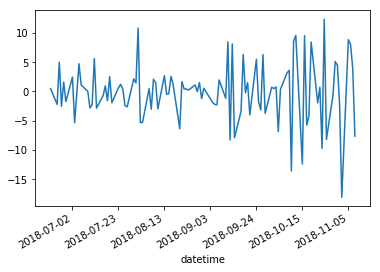

In [18]:
df['Close Second Difference'].plot()

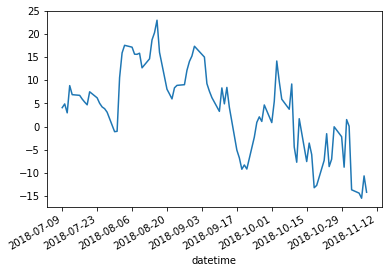

In [19]:
df['Seasonal Difference'] = df['Close'] - df['Close'].shift(12)
df['Seasonal Difference'].plot()

In [20]:
adf_check(df['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test
ADF Test Statistic : -0.20864144369161344
p-value : 0.9374837110639272
# Lags Used : 12
Number of Observations Used : 75
evidencia débil contra hipótesis nula, las series de tiempo tienen una raíz unitaria, lo que indica que no es estacionaria


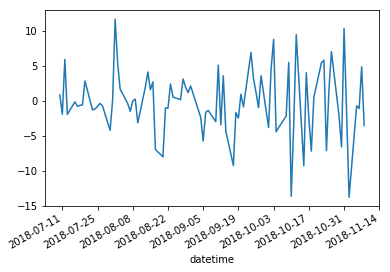

In [21]:
df["Seasonal First Difference"] = df["Close First Difference"] - df["Close First Difference"].shift(12)
df["Seasonal First Difference"].plot()

In [22]:
adf_check(df['Seasonal First Difference'].dropna())

Augmented Dickey-Fuller Test
ADF Test Statistic : -4.251784377136095
p-value : 0.0005378186443906724
# Lags Used : 11
Number of Observations Used : 75
evidencia fuerte contra la hipótesis nula, rechazar hipótesis nula. Los datos no tienen una raíz unitaria, lo que indica que es estacionaria


## ARIMA

In [23]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [24]:
# tenemos los datos estacionarios:
model = sm.tsa.statespace.SARIMAX(df['Close'], order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Close   No. Observations:                  100
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -247.719
Date:                            Thu, 08 Nov 2018   AIC                            501.439
Time:                                    23:18:05   BIC                            508.837
Sample:                                         0   HQIC                           504.418
                                            - 100                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0853      0.212      0.401      0.688      -0.331       0.502
ma.S.L12      -0.7056      0.236   

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


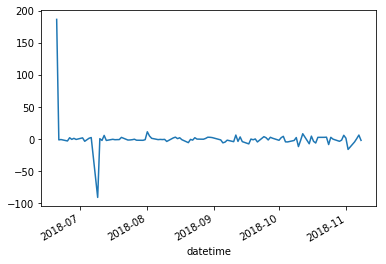

In [25]:
results.resid.plot()

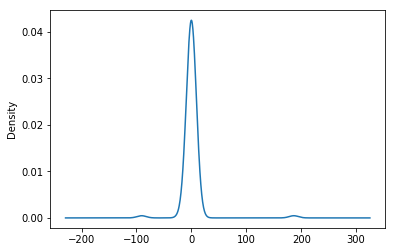

In [26]:
results.resid.plot(kind='kde')

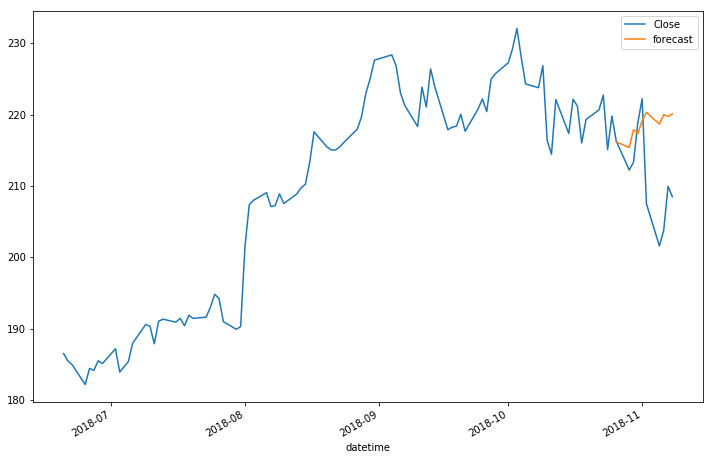

In [44]:
df['forecast'] = results.predict(start= 90, end = 99, dynamic= True)
df[['Close', 'forecast']].plot(figsize=(12, 8))

In [45]:
df.tail()

,Close,Close First Difference,Close Second Difference,Seasonal Difference,Seasonal First Difference,forecast
datetime,,,,,,
2018-11-02,207.48,-14.74,-18.10,-13.71,-13.78,220.294322
2018-11-05,201.59,-5.89,8.85,-14.43,-0.72,218.674391
2018-11-06,203.77,2.18,8.07,-15.54,-1.11,219.981311
2018-11-07,209.95,6.18,4.00,-10.70,4.84,219.743379
2018-11-08,208.49,-1.46,-7.64,-14.24,-3.54,220.115966
